畳み込みニューラルネットワーク (CNN)

CNNでは各層を流れるデータは4次元(batch_num, channel, height, width)

In [1]:
import numpy as np

#28*28, channel = 1 の画像10枚分
x = np.random.rand(10, 1, 28, 28)
print('x.shape = {}'.format(x.shape))
print('x[0].shape = {}'.format(x[0].shape))
print('x[1].shape = {}'.format(x[1].shape))
print('x[9].shape = {}'.format(x[9].shape))

x.shape = (10, 1, 28, 28)
x[0].shape = (1, 28, 28)
x[1].shape = (1, 28, 28)
x[9].shape = (1, 28, 28)


im2colの利用\
入力データの展開によって、入力データを2次元に変換する。\
    im2col(input_data, filter_h, filter_w, stride=1, pad=0)\
input_data; 入力データ(4次元配列)\
filter_h, filter_w; フィルターの高さ、幅\
stride; ストライド\
pad; パディング(余白)

In [4]:
import sys, os
sys.path.append('..')
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7) #3cahnnel,7*7, 1枚
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print('col1.shape = {}'.format(col1.shape))

x2 = np.random.rand(10, 3, 7, 7) #3cahnnel,7*7, 10枚
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print('col2.shape = {}'.format(col2.shape))

col1.shape = (9, 75)
col2.shape = (90, 75)


75はフィルター(3channel, 5 * 5)の要素の総和である\
9は出力データ(3 * 3)の要素の総和である\
90はbatch_num分かかっている。

Convolutionレイヤの実装

In [5]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        slef.stride = stride
        self.pad = pad
        
    def forward(self,x):
        FN, C, FH, FW = self.W.shape
        N, C. H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        #入力データの展開
        col = im2col(x, FH, FW, self.stride, self.pad)
        #重み(フィルタ)の展開
        col_W = self.W.reshape(FN, -1) #reshape()-1指定で(FN, a, b, c, ...)を(FN, a*b*c...)に変形
        
        out = np.dot(col, col_W) + self.b #()
        print(out.shape)
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        #transpose; (N, H, W, C) -> (N, C, H, W)
        return out
    
    #def backward()は省略

Poolingレイヤの実装

In [17]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        sels.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, N =x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        #展開
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w) #1行がpool内全要素
        #max
        out = np.max(col, axis=1) #行ごとに処理
        #reshape
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        return out
    
    #def backwardは省略

CNNの実装\
SimpleConvNet\
層\
Conv - ReLU - Pooling - Affine - ReLU - Affine - Softmax\
引数\
input_dim; 入力データ(channel, height, width)の次元\
con_param; hyper_params(filter_num, filter_size, stride, pad)\
hidden_size;隠れ層のニューロン層\
output_size; 出力のニューロン層\
weight_init_std; 初期化の際の重みの標準偏差\


In [14]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1}, hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num'] #30
        filter_size = conv_param['filter_size'] #5
        filter_pad = conv_param['pad'] #0
        filter_stride = conv_param['stride'] #1
        input_size = input_dim[1] #28
        conv_output_size = (input_size - filter_size + 2*filter_pad_) / filter_stride + 1 #(28 - 5 - 2*0) / 1 = 23
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2)) #int(30 * (23/2) *(23/2)) = int(3967.5) = 3968

        #重みparamsの設定
        self.params = {}
        #layer 1
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) #(30, 1, 5, 5)
        self.params['b1'] = np.zeros(filter_num) #(30)
        #layer 2
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size) #(3968, 100)
        self.params['b2'] = np.zeros(hidden_size) #(100)
        #layer 3
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size) #(100, 10)
        self.params['b3'] = np.zeros() #(10)

        #layerの作成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        #x入力データ, t教師ラベル
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        #forward
        self.loss(x, t)

        #backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

参考文献1を読みつつコードを実装することで、理解が深まった。\
ここからはサンプルコードを実行してMNISTデータを学習させる

In [15]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 5 #20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


train loss:2.3002398764578587
=== epoch:1, train acc:0.149, test acc:0.126 ===
train loss:2.298371257803771
train loss:2.297490749480363
train loss:2.2913744779127843
train loss:2.2840852806787915
train loss:2.282829351624994
train loss:2.267165012701346
train loss:2.261031785709768
train loss:2.240026819601695
train loss:2.213219709791695
train loss:2.1996138422517735
train loss:2.1582591387757892
train loss:2.1262225013779172
train loss:2.099063039589664
train loss:2.0641097276628373
train loss:2.003297540029907
train loss:1.9296165504882703
train loss:1.8757231146506053
train loss:1.804652374122552
train loss:1.7848511100964155
train loss:1.5773035299715574
train loss:1.586779889634354
train loss:1.5598277055767718
train loss:1.4109893751445728
train loss:1.3177917877323344
train loss:1.2727157834291487
train loss:1.2104560514334282
train loss:1.1557761485208142
train loss:1.0777139486577232
train loss:1.0331983871696082
train loss:0.9648802496765242
train loss:0.9724607835532837
tr

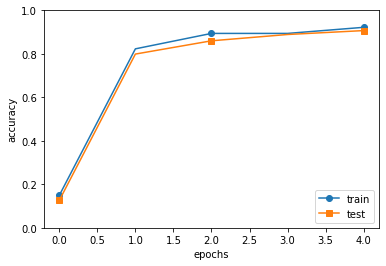

In [16]:
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

accuracyの値を見ると、エポックが大きくなるほどaccuracyも大きくなっていて、最終的に0.9近くまで行っている。trainとtestで大きな乖離がないことから過学習も起きていないと判断できる。この規模でのニューラルネットで90%程度の精度があるのに注目したい。

感想\
今回は畳み込みニューラルネットワークについて学習した。行列を展開して形状を変化させることで内積計算に帰着できることに驚いた。考えた人は本当に賢いなと感じた。また、ローカルで自分のPC上で実行したが、計算に時間がかかるようになってきた。\
今回で合同の輪読会は終了だが、ここで学んだことを自然言語処理に応用できるようしっかり復習したい。

参考文献
1. ゼロから作るDeep Learning -Pythonで学ぶディープランニングの理論と実装